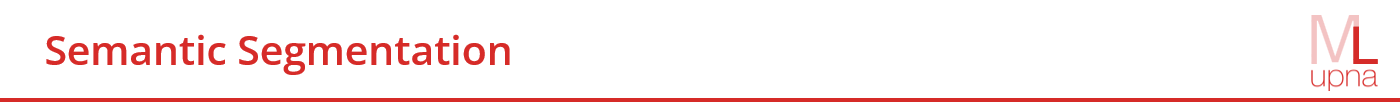

In [21]:
# Buid dataset from folder structure

from glob import glob
import pandas as pd

images = glob('./clothes/*/images/*')
df = pd.DataFrame(images, columns=['image_path'])
df['mask_path'] = df.image_path.apply(lambda x : x.replace('/images/', '/labels/').replace('.jpg', '.png'))
df['set'] = df.image_path.apply(lambda x : x.split('/')[2])
df.head()

,image_path,mask_path,set
0,./clothes/test/images/0851.jpg,./clothes/test/labels/0851.png,test
1,./clothes/test/images/0852.jpg,./clothes/test/labels/0852.png,test
2,./clothes/test/images/0853.jpg,./clothes/test/labels/0853.png,test
3,./clothes/test/images/0854.jpg,./clothes/test/labels/0854.png,test
4,./clothes/test/images/0855.jpg,./clothes/test/labels/0855.png,test


In [22]:
import pytorch_lightning as pl
import os
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision.models import ResNet18_Weights
from skimage.io import imread  # or your preferred image loader



In [23]:
DATA_DIR = 'clothes'
class_dict = pd.read_csv(os.path.join(DATA_DIR, 'class_dict.csv'))
# Get class names
class_names = class_dict['class_name'].tolist()
# Rewriting 'null' class to prevent a NaN value 
class_names[0] = 'null'
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('\nClass Names: ', class_names)
print('\nClass RGB values: ', class_rgb_values)


All dataset classes and their corresponding RGB values in labels:

Class Names:  ['null', 'accessories', 'bag', 'belt', 'blazer', 'blouse', 'bodysuit', 'boots', 'bra', 'bracelet', 'cape', 'cardigan', 'clogs', 'coat', 'dress', 'earrings', 'flats', 'glasses', 'gloves', 'hair', 'hat', 'heels', 'hoodie', 'intimate', 'jacket', 'jeans', 'jumper', 'leggings', 'loafers', 'necklace', 'panties', 'pants', 'pumps', 'purse', 'ring', 'romper', 'sandals', 'scarf', 'shirt', 'shoes', 'shorts', 'skin', 'skirt', 'sneakers', 'socks', 'stockings', 'suit', 'sunglasses', 'sweater', 'sweatshirt', 'swimwear', 't-shirt', 'tie', 'tights', 'top', 'vest', 'wallet', 'watch', 'wedges']

Class RGB values:  [[69, 6, 90], [70, 12, 95], [71, 18, 101], [72, 25, 107], [72, 30, 112], [72, 35, 116], [71, 40, 120], [70, 47, 124], [69, 52, 127], [68, 57, 130], [66, 61, 132], [64, 67, 135], [62, 72, 136], [61, 76, 137], [58, 82, 139], [56, 86, 139], [54, 90, 140], [52, 94, 141], [50, 99, 141], [48, 103, 141], [46, 107, 142], [

In [24]:
def rgb_to_class(mask, class_rgb_values):
    """
    Convert an RGB segmentation mask to a class index mask.
    mask: (H, W, 3)
    returns: (H, W) with class IDs.
    """
    h, w, _ = mask.shape
    mask_flat = mask.reshape(-1, 3)

    class_id_mask = np.zeros((h*w,), dtype=np.uint8)

    for class_id, rgb in enumerate(class_rgb_values):
        matches = np.all(mask_flat == rgb, axis=-1)
        class_id_mask[matches] = class_id

    return class_id_mask.reshape(h, w)


def class_to_rgb(mask, class_rgb_values):
    """
    Convert a class-index mask (H,W) back to an RGB mask (H,W,3)
    """
    h, w = mask.shape
    rgb_mask = np.zeros((h, w, 3), dtype=np.uint8)

    for class_id, rgb in enumerate(class_rgb_values):
        rgb_mask[mask == class_id] = rgb

    return rgb_mask

class CCPDataset(torch.utils.data.Dataset):

    def __init__(self, df, class_rgb_values=class_rgb_values, patch_size=224, transforms=None):
        super(CCPDataset, self).__init__()
        self.df = df
        self.ps = patch_size
        self.transforms = transforms
        self.class_rgb_values = class_rgb_values

    def __random_crop__(self, img, mask):
        H, W, _ = img.shape
        
        y = np.random.randint(0, H - self.ps + 1)
        x = np.random.randint(0, W - self.ps + 1)
        
        return (
            img[y:y+self.ps, x:x+self.ps, :],
            mask[y:y+self.ps, x:x+self.ps, :]
        )

    def __getitem__(self, idx):

        r = self.df.iloc[idx]

        # Read image and mask
        x = imread(r.image_path)
        y = imread(r.mask_path)

        # Take random patch
        x, y = self.__random_crop__(x, y)

        # Convert mask to class IDs
        y = rgb_to_class(y, self.class_rgb_values)

        # Convert to tensors
        x = torch.from_numpy(x.transpose(2, 0, 1)).float()  # (C,H,W)
        y = torch.from_numpy(y).long()                      # (H,W)

        # Apply transforms (image only)
        if self.transforms:
            x = self.transforms(x)

        return x, y

    def __len__(self):
        return len(self.df)

    def __show_item__(self, x, y, idx=None):
        """
        Display an image and its corresponding segmentation mask.
        x: tensor (C,H,W)
        y: tensor (H,W) with class IDs
        idx: optional, dataset index
        """
        # Convert image to HWC for plotting
        x_np = x.permute(1, 2, 0).numpy().astype(np.uint8)
        
        # Convert class mask to RGB
        y_rgb = class_to_rgb(y.numpy(), self.class_rgb_values)
        
        plt.figure(figsize=(10, 5))
        
        plt.subplot(1, 2, 1)
        plt.imshow(x_np)
        plt.title(f"Image {idx}" if idx is not None else "Image")
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(y_rgb)
        plt.title("Mask")
        plt.axis('off')
        
        plt.show()



class DataModule(pl.LightningDataModule):
    def __init__(self, df, bs, ps, num_workers=4):
        super().__init__()
        self.df = df
        self.bs = bs
        self.ps = ps
        self.num_workers = num_workers

    def setup(self, stage): # Data preparation and transforms
        transforms = ResNet18_Weights.IMAGENET1K_V1.transforms()
        self.train_ds = CCPDataset(df=df.query('set == "train"'), patch_size=self.ps, transforms=transforms)
        self.valid_ds = CCPDataset(df=df.query('set == "valid"'), patch_size=self.ps, transforms=transforms)
        self.test_ds = CCPDataset(df=df.query('set == "test"'), patch_size=self.ps, transforms=transforms)

    def train_dataloader(self): return torch.utils.data.DataLoader(self.train_ds, batch_size=self.bs, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self): return torch.utils.data.DataLoader(self.valid_ds, batch_size=self.bs, shuffle=False, num_workers=self.num_workers)

    def test_dataloader(self): return torch.utils.data.DataLoader(self.test_ds, batch_size=self.bs, shuffle=False, num_workers=self.num_workers)

In [25]:
import segmentation_models_pytorch as smp
from lightning.pytorch.loggers import CSVLogger
from torch.nn import functional as F
from collections import defaultdict

# UNet

In [26]:
model = smp.Unet(
    encoder_name='resnet18',
    encoder_weights='imagenet',
    in_channels=3,
    classes=59
)

model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [27]:
class LightningModule(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.save_hyperparameters()
        
        self.model = smp.Unet(
            encoder_name='resnet18',
            encoder_weights='imagenet',
            in_channels=3,
            classes=59
        )

        self.training_step_outputs = defaultdict(float)
        self.validation_step_outputs = defaultdict(float)
        
    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)  # (B, 59, H, W)
        loss = F.cross_entropy(logits, y)
        self.log('train_loss', loss, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.log('val_loss', loss, on_epoch=True)
        return loss


In [28]:
# Set random seed for reproducibility
pl.seed_everything(seed=42, workers=True)

# Intantiate LightningModule
lightning_module = LightningModule()

# Define a CSV logger to store training/validation metrics in CSV format.
csv_logger = CSVLogger(save_dir=os.getcwd(), name="experiments/ccp_unet")

# Define a checkpoint callback:
# It will save the model with the lowest validation loss ("best_valid_loss.ckpt").
model_checkpoint_callback = pl.callbacks.model_checkpoint.ModelCheckpoint(
    monitor='val_loss',mode='min', filename='best_valid_loss', verbose=True, save_last=False)

# Create a PyTorch Lightning trainer
trainer = pl.Trainer(max_epochs=3, logger=csv_logger, callbacks=[model_checkpoint_callback])

# Load the data module
data_module = DataModule(df, bs=64, ps=224)

# Train the model with the trainer, passing the core LightningModule and data module.
trainer.fit(lightning_module, data_module)

Seed set to 42


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | Unet | 14.3 M | train
---------------------------------------
14.3 M    Trainable params
0         Non-trainable params
14.3 M    Total params
57.346    Total estimated model params size (MB)
140       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/alumno/py313ml/.venv/lib/python3.13/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (11) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 11: 'val_loss' reached 3.25110 (best 3.25110), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/ccp_unet/version_5/checkpoints/best_valid_loss.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 22: 'val_loss' reached 2.40592 (best 2.40592), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/ccp_unet/version_5/checkpoints/best_valid_loss.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 33: 'val_loss' reached 1.83519 (best 1.83519), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/ccp_unet/version_5/checkpoints/best_valid_loss.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=3` reached.


   epoch  step  train_loss_epoch  val_loss
0      0    10          3.328151  3.251099
1      1    21          2.275380  2.405916
2      2    32          1.772303  1.835187


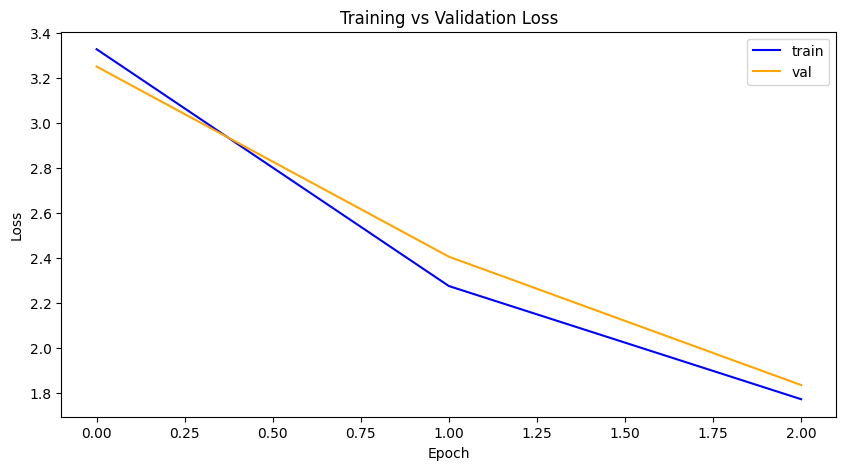

In [29]:
metric_df = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')
metric_df = metric_df.groupby('epoch', as_index=False).first()
print(metric_df.head())

f, ax = plt.subplots(1, 1, figsize=(10, 5))
metric_df.train_loss_epoch.plot(ax=ax, color='blue', label='train')
metric_df.val_loss.plot(ax=ax, color='orange', label='val')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training vs Validation Loss')
ax.legend()
plt.show()

# DeepLab v3

In [30]:
model = smp.DeepLabV3Plus(
    encoder_name='resnet18',
    encoder_weights='imagenet',
    in_channels=3,
    classes=59
)

model

DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

In [31]:
class LightningModule(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.save_hyperparameters()
        
        self.model = smp.DeepLabV3Plus(
            encoder_name='resnet101',     # better accuracy
            encoder_weights='imagenet',
            in_channels=3,
            classes=59,
            encoder_output_stride=16      # better detail
        )


        self.training_step_outputs = defaultdict(float)
        self.validation_step_outputs = defaultdict(float)
        
    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)  # (B, 59, H, W)
        loss = F.cross_entropy(logits, y)
        self.log('train_loss', loss, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        return loss


In [32]:
pl.seed_everything(seed=42, workers=True)

lightning_module = LightningModule()

csv_logger = CSVLogger(
    save_dir=os.getcwd(),
    name="experiments/ccp_deeplabv3plus"
)

model_checkpoint_callback = pl.callbacks.model_checkpoint.ModelCheckpoint(
    monitor='val_loss',
    mode='min',
    filename='best_valid_loss',
    verbose=True,
    save_last=False
)

trainer = pl.Trainer(
    max_epochs=3,
    logger=csv_logger,
    callbacks=[model_checkpoint_callback]
)

data_module = DataModule(df, bs=64, ps=224)

trainer.fit(lightning_module, data_module)


Seed set to 42


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/179M [00:00<?, ?B/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | DeepLabV3Plus | 45.7 M | train
------------------------------------------------
45.7 M    Trainable params
0         Non-trainable params
45.7 M    Total params
182.738   Total estimated model params size (MB)
343       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/alumno/py313ml/.venv/lib/python3.13/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (11) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 11: 'val_loss' reached 3.53032 (best 3.53032), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/ccp_deeplabv3plus/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 22: 'val_loss' reached 2.80450 (best 2.80450), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/ccp_deeplabv3plus/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 33: 'val_loss' reached 1.62105 (best 1.62105), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/ccp_deeplabv3plus/version_0/checkpoints/best_valid_loss.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=3` reached.


   epoch  step  train_loss_epoch  val_loss
0      0    10          2.726046  3.530323
1      1    21          1.679574  2.804497
2      2    32          1.505373  1.621050


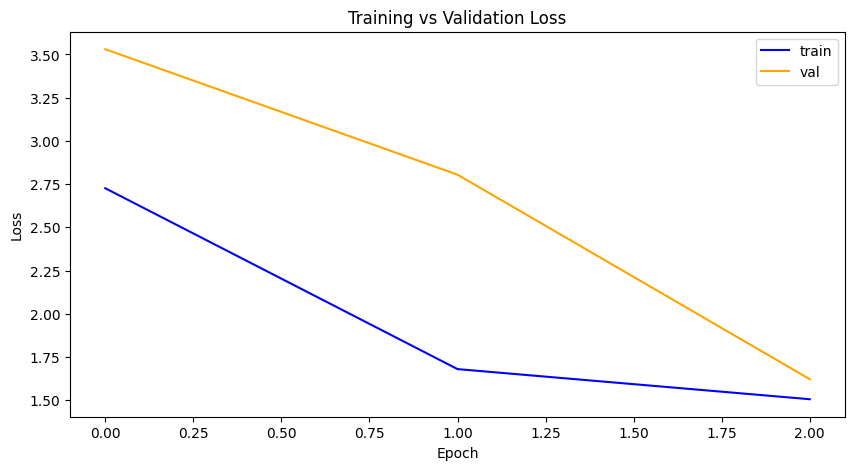

In [33]:
metric_df = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')
metric_df = metric_df.groupby('epoch', as_index=False).first()
print(metric_df.head())

f, ax = plt.subplots(1, 1, figsize=(10, 5))
metric_df.train_loss_epoch.plot(ax=ax, color='blue', label='train')
metric_df.val_loss.plot(ax=ax, color='orange', label='val')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training vs Validation Loss')
ax.legend()
plt.show()